Title

In [1]:
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 8)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

Introduction

Preliminary exploratory data analysis

In [2]:
## Load datasets from URL

algerian_forest_fire_Bejaia <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv", 
                                 skip = 1, n_max = 122) %>%
    mutate(Region = "Bejaia")

algerian_forest_fire_Sidi_Bel_Abbes <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv",
                                               skip = 126) %>%
    mutate(Region = "Sidi Bel Abbes")

## Merge datasets of the two regions

algeria_forest_fire_all_data <- rbind(algerian_forest_fire_Bejaia, algerian_forest_fire_Sidi_Bel_Abbes) %>%
    mutate(Classes = as_factor(Classes)) %>%
    mutate(Region = as_factor(Region))

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),
  DC = col_double(),
  ISI = col_double(),
  BUI = col_double(),
  FWI = col_double(),
  Classes = col_character()
)

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),
  DC = col_character(),
  ISI = col_double(),
  BUI = col_double(),
  FWI = col_character(),
  Classes = col_character()
)

Warning message:
“1 parsing failure.
row col   expected     actual                                                                                                       file
 44  -- 14 columns 13 columns 'https://archive.ics.uci.edu/ml/machine-lear

In [3]:
## Manually set values of incorrect column, convert DC and FWI to numeric type

algeria_forest_fire_all_data[166, 10] <- '14.6'
algeria_forest_fire_all_data[166, 11] <- 9
algeria_forest_fire_all_data[166, 12] <- 12.5
algeria_forest_fire_all_data[166, 13] <- '10.4'
algeria_forest_fire_all_data[166, 14] <- "fire" 

algeria_forest_fire_all_data <- algeria_forest_fire_all_data %>%
    mutate(DC = as.numeric(DC)) %>%
    mutate(FWI = as.numeric(FWI))

# ## Create date column
# algeria_forest_fire_all_data <- algeria_forest_fire_all_data %>%
#     mutate(date = as.Date(paste(year, month, day, sep='-')))

In [4]:
## Create training dataset

set.seed(38)

forest_fire_split <- initial_split(algeria_forest_fire_all_data, prop = 0.65, strata = Classes)
forest_fire_train <- training(forest_fire_split)
forest_fire_test <- testing(forest_fire_split)

forest_fire_train

day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
01,06,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,Bejaia
02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,Bejaia
03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,Bejaia
04,06,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,Bejaia
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
26,09,2012,30,65,14,0.0,85.4,16.0,44.5,4.5,16.9,6.5,fire,Sidi Bel Abbes
27,09,2012,28,87,15,4.4,41.1,6.5,8.0,0.1,6.2,0.0,not fire,Sidi Bel Abbes
28,09,2012,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2,not fire,Sidi Bel Abbes
29,09,2012,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,not fire,Sidi Bel Abbes


In [5]:
forest_fire_predictors <- forest_fire_train %>%
    select(Temperature, RH, Rain, FFMC, Classes)

In [6]:
## Explore means of predictor variables

fire_means <- forest_fire_predictors %>%
    filter(Classes == "fire") %>%
    select (-Classes) %>%
    map_df(mean)

not_fire_means <- forest_fire_predictors %>%
    filter(Classes == "not fire") %>%
    select(-Classes) %>%
    map_df(mean)

## Explore medians of predictor variables

fire_medians <- forest_fire_predictors %>%
    filter(Classes == "fire") %>%
    select (-Classes) %>%
    map_df(median)

not_fire_medians <- forest_fire_predictors %>%
    filter(Classes == "not fire") %>%
    select(-Classes) %>%
    map_df(median)

## Explore max values of predictor variables

fire_max <- forest_fire_predictors %>%
    filter(Classes == "fire") %>%
    select (-Classes) %>%
    map_df(max)

not_fire_max <- forest_fire_predictors %>%
    filter(Classes == "not fire") %>%
    select(-Classes) %>%
    map_df(max)

## Explore min values of predictor variables

fire_min <- forest_fire_predictors %>%
    filter(Classes == "fire") %>%
    select (-Classes) %>%
    map_df(min)

not_fire_min <- forest_fire_predictors %>%
    filter(Classes == "not fire") %>%
    select(-Classes) %>%
    map_df(min)

In [7]:
classes <- tibble(Classes = c("fire", "not fire"))

means <- classes %>%
    bind_cols(rbind(fire_means, not_fire_means))
means

medians <- classes %>%
    bind_cols(rbind(fire_medians, not_fire_medians))
medians

maxima <- classes %>%
    bind_cols(rbind(fire_max, not_fire_max))
maxima

minima <- classes %>%
    bind_cols(rbind(fire_min, not_fire_min))
minima

Classes,Temperature,RH,Rain,FFMC
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
fire,33.85556,56.26667,0.04888889,87.47889
not fire,29.75362,69.92754,1.65652174,64.85072


Classes,Temperature,RH,Rain,FFMC
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
fire,34,56.5,0.0,87.8
not fire,30,71.0,0.5,68.3


Classes,Temperature,RH,Rain,FFMC
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
fire,42,88,0.6,96.0
not fire,38,89,16.8,81.1


Classes,Temperature,RH,Rain,FFMC
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
fire,26,21,0,80.2
not fire,22,45,0,28.6


In [8]:
summary <- forest_fire_predictors %>%
    group_by(Classes) %>%
    summarize(mean_temp = mean(Temperature),
             mean_RH = mean(RH),
             mean_rain = mean(Rain),
             mean_FFMC = mean(FFMC),
             count = n())

summary

`summarise()` ungrouping output (override with `.groups` argument)



Classes,mean_temp,mean_RH,mean_rain,mean_FFMC,count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
not fire,29.75362,69.92754,1.65652174,64.85072,69
fire,33.85556,56.26667,0.04888889,87.47889,90


In [35]:
options(repr.plot.width = 8, repr.plot.height = 6)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



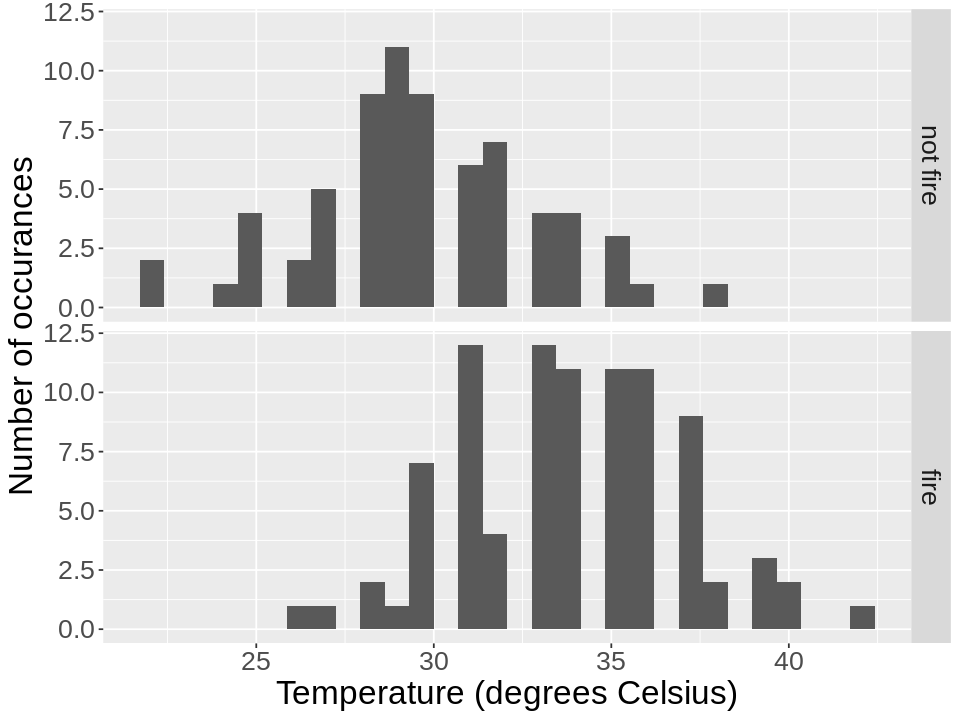

In [36]:
temp_distribution_plot_fire <- forest_fire_predictors %>%
    ggplot(aes(x = Temperature)) +
    geom_histogram() +
    xlab("Temperature (degrees Celsius)") +
    facet_grid(Classes ~ .) +
    ylab("Number of occurances") +
    theme(text = element_text(size = 20))

temp_distribution_plot_fire

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



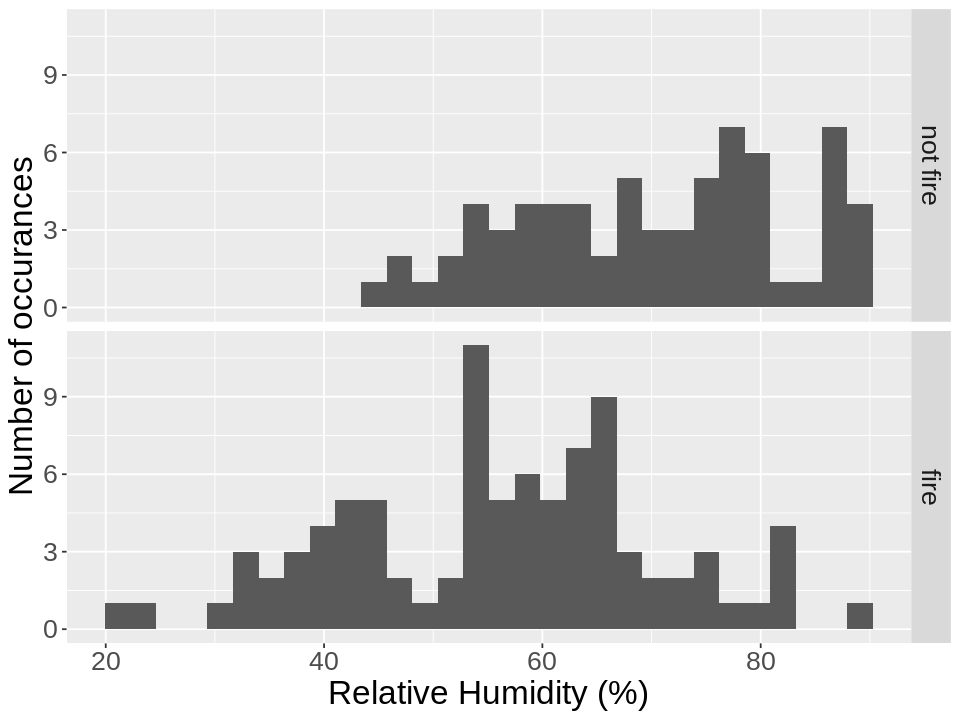

In [37]:
RH_distribution_plot_fire <- forest_fire_predictors %>%
    ggplot(aes(x = RH)) +
    geom_histogram() +
    xlab("Relative Humidity (%)") +
    facet_grid(Classes ~ .) +
    ylab("Number of occurances") +
    theme(text = element_text(size = 20))

RH_distribution_plot_fire

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



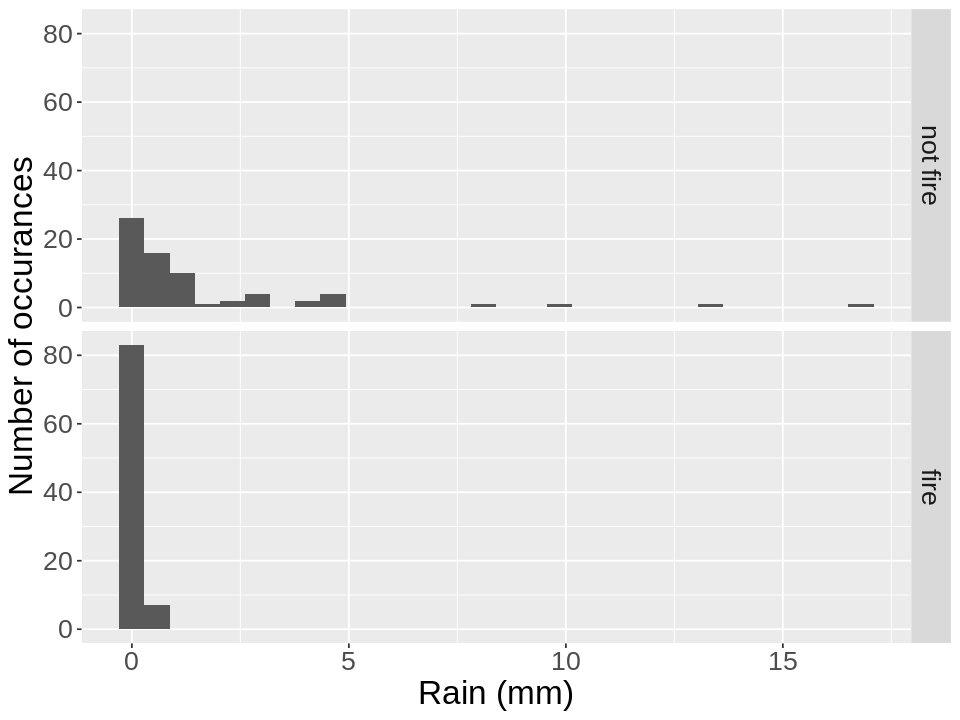

In [38]:
rain_distribution_plot_fire <- forest_fire_predictors %>%
    ggplot(aes(x = Rain)) +
    geom_histogram() +
    xlab("Rain (mm)") +
    facet_grid(Classes ~ .) +
    ylab("Number of occurances") +
    theme(text = element_text(size = 20))

rain_distribution_plot_fire

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



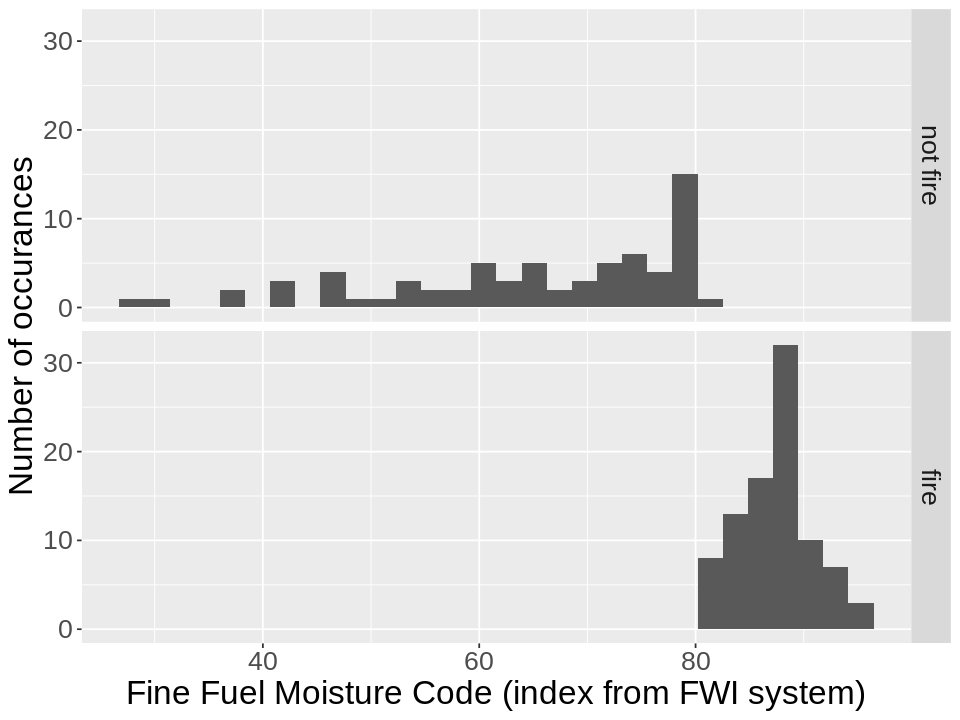

In [39]:
FFMC_distribution_plot_fire <- forest_fire_predictors %>%
    ggplot(aes(x = FFMC)) +
    geom_histogram() +
    xlab("Fine Fuel Moisture Code (index from FWI system)") +
    facet_grid(Classes ~ .) +
    ylab("Number of occurances") +
    theme(text = element_text(size = 20))

FFMC_distribution_plot_fire

In [45]:
options(repr.plot.width = 7, repr.plot.height = 6)

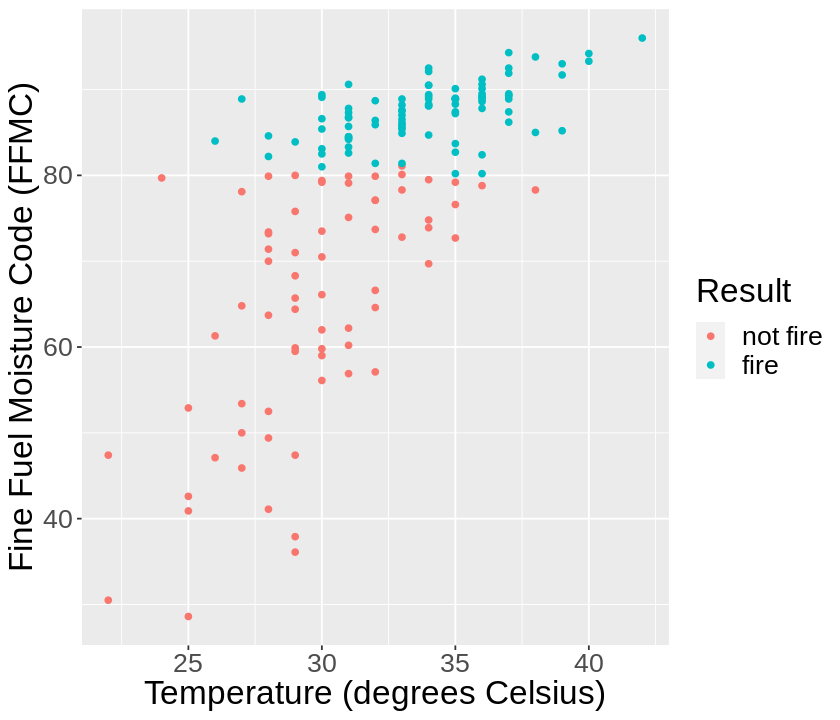

In [46]:
temp_v_ffmc <- forest_fire_predictors %>%
    ggplot(aes(x = Temperature, y = FFMC, color = Classes)) + 
    geom_point() +
    labs (x = "Temperature (degrees Celsius)", y = "Fine Fuel Moisture Code (FFMC)", color = "Result") + #weird title for color
    theme(text = element_text(size = 20))

temp_v_ffmc

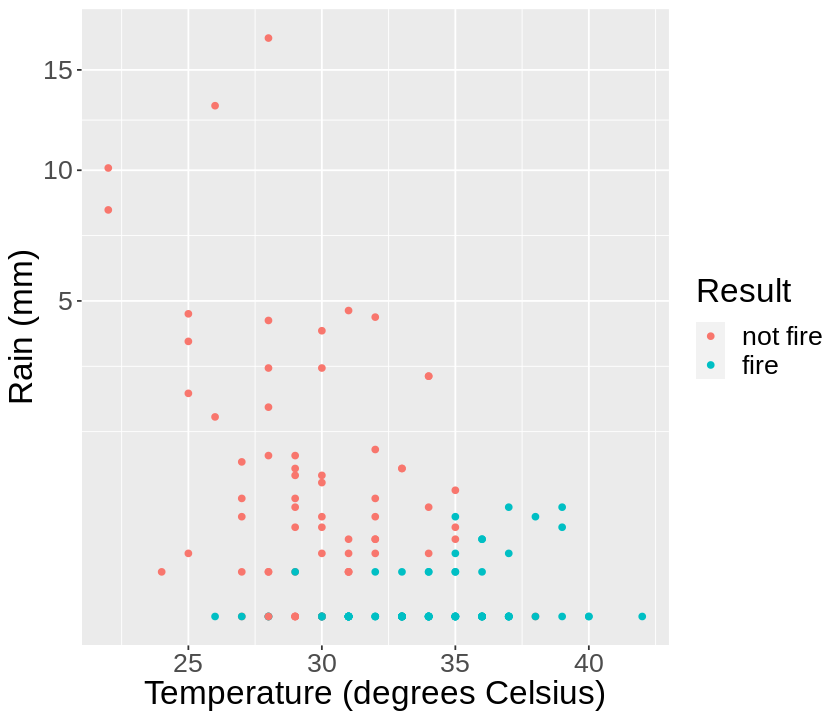

In [47]:
temp_v_rain <- forest_fire_predictors %>%
    ggplot(aes(x = Temperature, y = Rain, color = Classes)) + 
    geom_point() +
    scale_y_sqrt() +
    labs (x = "Temperature (degrees Celsius)", y = "Rain (mm)", color = "Result") + #weird title for color
    theme(text = element_text(size = 20))

temp_v_rain

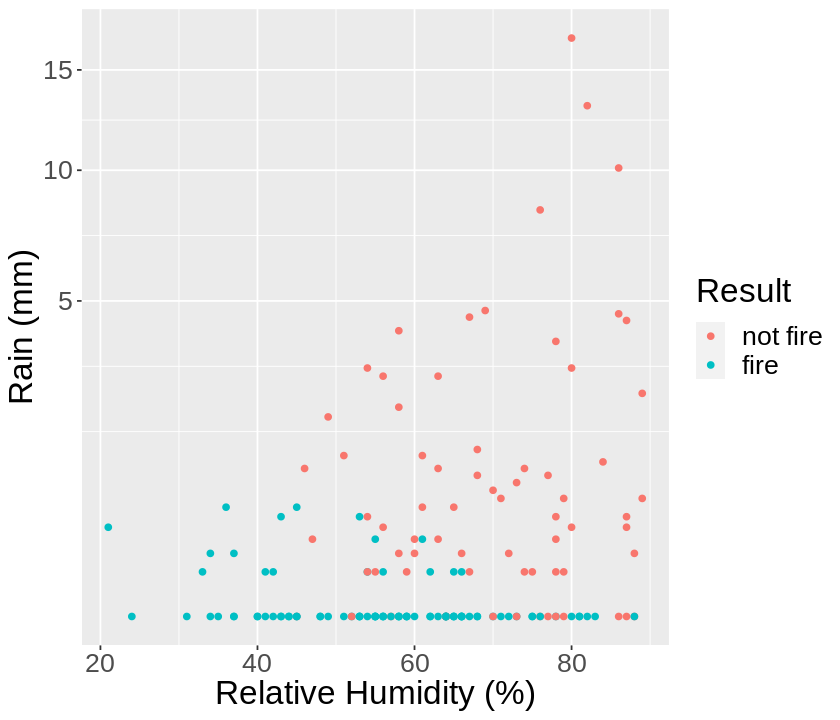

In [48]:
humidity_v_rain <- forest_fire_predictors %>%
    ggplot(aes(x = RH, y = Rain, color = Classes)) + 
    geom_point() +
    scale_y_sqrt() +
    labs (x = "Relative Humidity (%)", y = "Rain (mm)", color = "Result") + #weird title for color
    theme(text = element_text(size = 20))

humidity_v_rain

Methods

Expected outcomes and significance